# Deep Learning (with `torch`)

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from functools import partial
from tqdm import tqdm

In [2]:
# configure matplotlib output
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('config/clean.mplstyle') # this loads my personal plotting settings
col = mpl.rcParams['axes.prop_cycle'].by_key()['color']
%matplotlib inline

In [3]:
# if you have an HD display
%config InlineBackend.figure_format = 'retina'

In [4]:
# some warnings can get annoying
import warnings
warnings.filterwarnings('ignore')

## PyTorch (`torch`)

Now we're moving on to `torch`, a very popular machine learning framework, probably the most popular nowadays. Like `jax`, torch implements an interface very similar to that of `numpy`. However, instead of being basically a drop in replacement, there are some differences and all the functions are exposed directly in the top-level `torch` module.

First, arrays aren't called `array` anymore, they're called `tensor`. As with `jax`, you need to be a little more careful about array types, as most things are done in 32-bit, and arrays always have a device that they are located on, which can be either `cpu` or `cuda` most of the time.

In [5]:
x = torch.tensor([1.0, 2.0, 3.0])
print(x.device, x.dtype)
x

cpu torch.float32


tensor([1., 2., 3.])

As an example, in `numpy` and `jax`, you can take the mean of an integer or boolean array. However, in `torch` this will throw an error, as `mean` would then return a number of a different type (`float`). Here's an example

In [6]:
try:
    b = torch.tensor([1, 2, 3])
    b.mean()
except Exception as e:
    print(e)

mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long


We'll want to find the mean of some boolean arrays below, so let's define a convenience function. This uses the `to` function, which allows you to mutate properties of a `tensor` such as `device` or `dtype`. Also note that below we use chaining of functions on tensors, which is quite common in `torch` world, rather than top-level `torch` functions.

In [7]:
bool_mean = lambda x: x.to(dtype=torch.float).mean()

### Neural Classifier

First let's reimplement the neural classifier model from last lecture in `torch`. The data generation is nearly identical to before. Note that `categ` is a boolean but is encoded as an `int` here. After generating the raw data, we pass it to `TensorDataset` to create a single dataset object. This way we don't have to carry around multiple tensors. Then we pass this to `DataLoader`, which takes care of things like randomly shuffling the data and making batches. If you use the dataloader object as an iterator, it will return batches of `space`/`categ` pairs.

In [8]:
# simple hyperplane model
dim = 100
true_beta0 = 0.0
true_beta1 = 1.0*torch.ones(dim)

In [9]:
# generate raw data
N = 10000
space = torch.randn(N, dim)
rando = torch.tensor(np.random.logistic(size=N))
categ = (true_beta0 + space @ true_beta1 + rando > 0).to(dtype=torch.long)

In [10]:
# make dataset and loader
dataset = torch.utils.data.TensorDataset(space, categ)
dataload = torch.utils.data.DataLoader(dataset, batch_size=1000)

Now let's create the actual model, which is a `Module` object. This looks very similar to the `flax` notation. In this framework, any setup like layer creation is done in `__init__`, while the actual prediction is done in the `forward` function. Notice that here we also return a pair of logits that defines the probabilities of the respective outcomes (`0` and `1`). Sadly, we don't have trees in `torch` world, so we just make a `tensor` of stats.

In [11]:
# same neural as a module
class Neural(nn.Module):
    def __init__(self, hid=2):
        super().__init__()
        self.linear0 = nn.Linear(dim, hid)
        self.linear1 = nn.Linear(hid, 2)

    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.linear1(x)
        return x

In [12]:
def neural_stats(logits, y):
    predict = logits[:, 1] >= logits[:, 0]
    target = y == 1
    return torch.tensor([
        bool_mean(predict == target),
        bool_mean(predict & ~target),
        bool_mean(~predict & target),
    ])

Now let's run it! There's a lot going on in this cell. You can see it's not so simple and elegant as in `jax`. Some of this is for the sake of performance. We don't have to do anything like `jit` here, but things are still pretty fast, and the cost is slightly clunkier notation. There are two primary differences below. One is this code block:
```python
optim.zero_grad()
loss.backward()
optim.step()
```
When we run `model` and `bce_loss`, this is the "forward" pass where we compute values. To get the gradients, we have to a do a "backward". That's what's happening here. We zero out the stored gradients, accumulate them with a backward pass, then take a step based on those gradients. We run the training loop for 25 "epochs", which means we run it over the entire dataset 25 times.

The other difference is the `logits.detach()` command. This actually isn't truly necessary, we could have just written `logit`. All that `detach` does it tell it to stop tracking gradient information for that calculation, as we don't need the gradients for the `neural_stats` values. Similarly, the `numpy` command converts a tensor into the analgous `numpy` array.

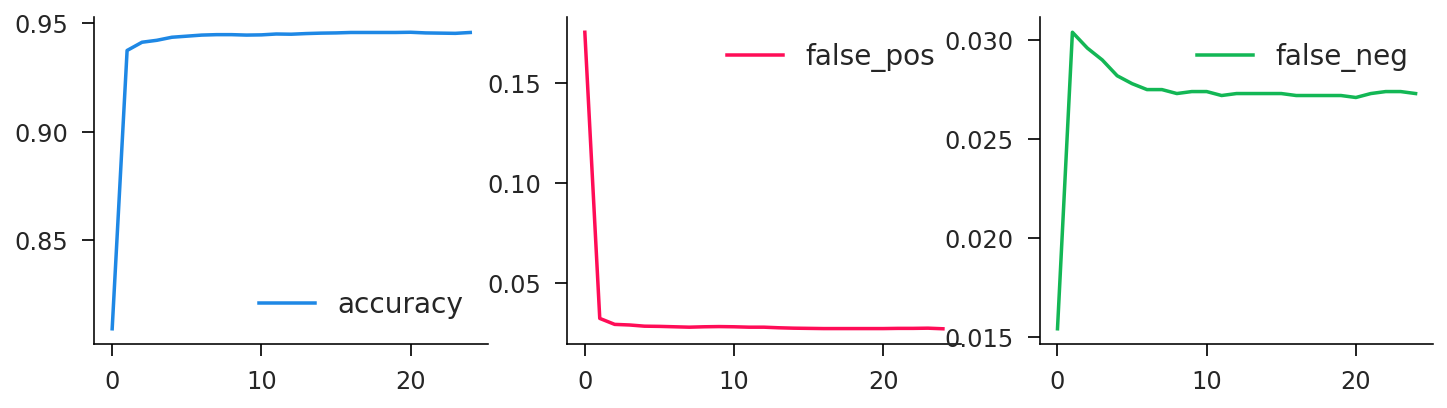

In [13]:
# make model and optimizer
model = Neural()
optim = torch.optim.RMSprop(model.parameters(), lr=0.01)

# define loss function
bce_loss = nn.CrossEntropyLoss()

# track history
history = []

# go for many iterations
for i in range(25):
    # accumulate stats per batch
    nbatch = 0
    stats = torch.zeros(3)

    # iterate over batches
    for x, y in dataload:
        # compute loss
        logits = model(x)
        loss = bce_loss(logits, y)

        # update params
        optim.zero_grad()
        loss.backward()
        optim.step()

        # add batch stats
        nbatch += 1
        stats += neural_stats(logits.detach(), y)

    # make it a mean    
    stats /= nbatch
    history.append(stats)

# turn history into dataframe
history = pd.DataFrame(
    torch.stack(history).numpy(),
    columns=['accuracy', 'false_pos', 'false_neg']
)
history.plot(subplots=True, layout=(1, 3), figsize=(12, 3));

### Neural Trader

Okay, time to make some money!! We're going to generate some data on "returns", which are just random normals, which may or may not have a predictable component. There is a single security, so our choice is what fraction of our money to invest in each period. We're assuming we can only take "long" positions, so this is a number $s \in [0,1]$. Our input data is the history of the past $L$ realizations of returns. From a single series of length $T$, we can turn this into a set of $T-L$ overlapping history/outcome pairs.

In [14]:
# parameters
N = 1000 # number of training series
M = 100 # number of validation series
T = 20 # total time length
L = 4 # history window length
K = T - L # number of subseries

In [15]:
# generate overlapping sequences
def generate_sequences0(vec, l):
    n, t = vec.shape
    k = t - l
    series = torch.stack([vec[:, i:i+l] for i in range(k)], axis=-1)
    series = series.transpose(1, 2).reshape((n*k, -1))
    target = vec[:, l:].reshape((n*k,))
    return series, target

In [16]:
# generate overlapping sequences with l-length history and single outcome
def generate_sequences(vec, l):
    n, t = vec.shape
    k = t - l
    index0 = torch.arange(l).unsqueeze(0) + torch.arange(k).unsqueeze(1)
    index = index0.flatten().expand(n, k*l)
    series = torch.gather(vec, 1, index).reshape(n*k, l)
    target = vec[:, l:].reshape(n*k)
    return series, target

The model is a two layer neural network as before. The output for each observation is a scalar in $[0,1]$, which we accomplish with the `sigmoid` on output. Note that that final `squeeze` operation makes sure it's a scalar rather than a length-1 tensor.

In [17]:
# simple neural trader (long only)
class NeuralTrader(nn.Module):
    def __init__(self, lag=4, hid=5):
        super().__init__()
        self.linear0 = nn.Linear(lag, hid)
        self.linear1 = nn.Linear(hid, 1)

    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x.squeeze()

Now it is time to train. This is all quite similar to before. Notice the objective here is just the product of the position recommendation and the realized returns (averaged over the batch). One addition you'll notice is we wrap the epoch loop in the mysterious `tqdm`. This will function the same in the code but will also print out a neat little progress bar. Also, there are new `model.train()` and `model.eval()` commands. These are unecessary in the basic case, but we'll need them later.

In [18]:
def neural_trader(model, train_data, valid_data, lr=0.01, epochs=25, batch_size=1000):
    # make data loaders
    train_load = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_x, valid_y = valid_data.tensors

    # make model and optimizer
    optim = torch.optim.RMSprop(model.parameters(), lr=lr)

    # track history
    history = []

    # go for many iterations
    for i in tqdm(range(epochs)):
        n_batch = 0
        train_stats = torch.zeros(2)
        
        # iterate over batches
        model.train()
        for batch_x, batch_y in train_load:
            # compute loss
            recom = model(batch_x)
            retvrn = recom*batch_y
            loss = -retvrn.mean()

            # update params
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # training stats
            n_batch += 1
            train_stats += torch.tensor([recom.detach().mean(), retvrn.detach().mean()])

        # average training
        train_stats /= n_batch

        # validation stats
        model.eval()
        valid_recom = model(valid_x)
        valid_retvrn = valid_recom*valid_y
        valid_stats = torch.tensor([valid_recom.detach().mean(), valid_retvrn.detach().mean()])

        # make it a mean
        stats = torch.cat([train_stats, valid_stats])
        history.append(stats)

    # turn history into dataframe
    names = ['train_recom', 'train_return', 'valid_recom', 'valid_return']
    return pd.DataFrame(torch.stack(history).numpy(), columns=names)

### Overfitting

Now let's train this on some random data. Any returns we get should be purely noise, as these are just uncorrelated returns over time. You can see that we typically get 1-2% returns on the training data, while those in the validation set are over lower, but in general are quite noisy. The other thing to note is that for many runs, after some point in the training process we see the validation return start to go down, while the training return continues to rise. This is a classic signature of overfitting.

In [19]:
# generate training data
train_random_return = torch.randn(N, T)
train_random_series, train_random_target = generate_sequences(train_random_return, L)
train_random_data = torch.utils.data.TensorDataset(train_random_series, train_random_target)

# generate validation data
valid_random_return = torch.randn(M, T)
valid_random_series, valid_random_target = generate_sequences(valid_random_return, L)
valid_random_data = torch.utils.data.TensorDataset(valid_random_series, valid_random_target)

100%|█████████████████████████████████████████| 500/500 [00:59<00:00,  8.45it/s]


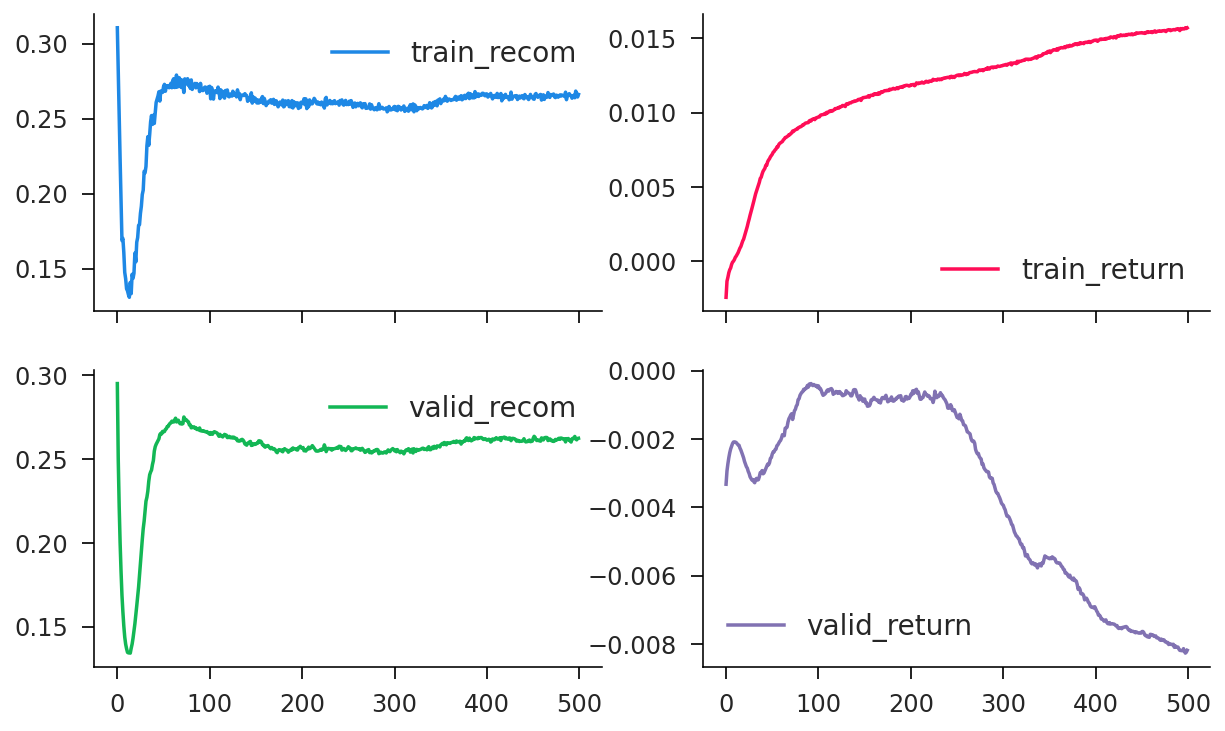

In [20]:
model_base = NeuralTrader(lag=L, hid=5)
history = neural_trader(model_base, train_random_data, valid_random_data, epochs=500)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

### Real Signal (Momentum)

Now let's at least give ourselves a chance and add in some momentum (EMH violation alert!). Obivously this can happen in certain markets, and I think there's even an explanation in efficient markets relating to stochastic discount factors. Like it's okay as long as returns are uncorrelated with the SDF. Anyway, that doesn't matter here, we can simulate whatever the hell we want.

In [21]:
# draw an MA(1) process with persistence ρ
def gen_ma1(N, T, ρ=0.5):
    tvec = torch.arange(T).flip(0)
    ρvec = (ρ**tvec).unsqueeze(0)
    shocks = torch.randn(N, T)
    values = (ρvec*shocks).cumsum(1)/ρvec
    return values

In [22]:
ρ = 0.2
train_moment_return = gen_ma1(N, T, ρ=ρ)
train_moment_series, train_moment_target = generate_sequences(train_moment_return, L)
train_moment_data = torch.utils.data.TensorDataset(train_moment_series, train_moment_target)
valid_moment_return = gen_ma1(M, T, ρ=ρ)
valid_moment_series, valid_moment_target = generate_sequences(valid_moment_return, L)
valid_moment_data = torch.utils.data.TensorDataset(valid_moment_series, valid_moment_target)

100%|█████████████████████████████████████████| 250/250 [00:27<00:00,  8.99it/s]


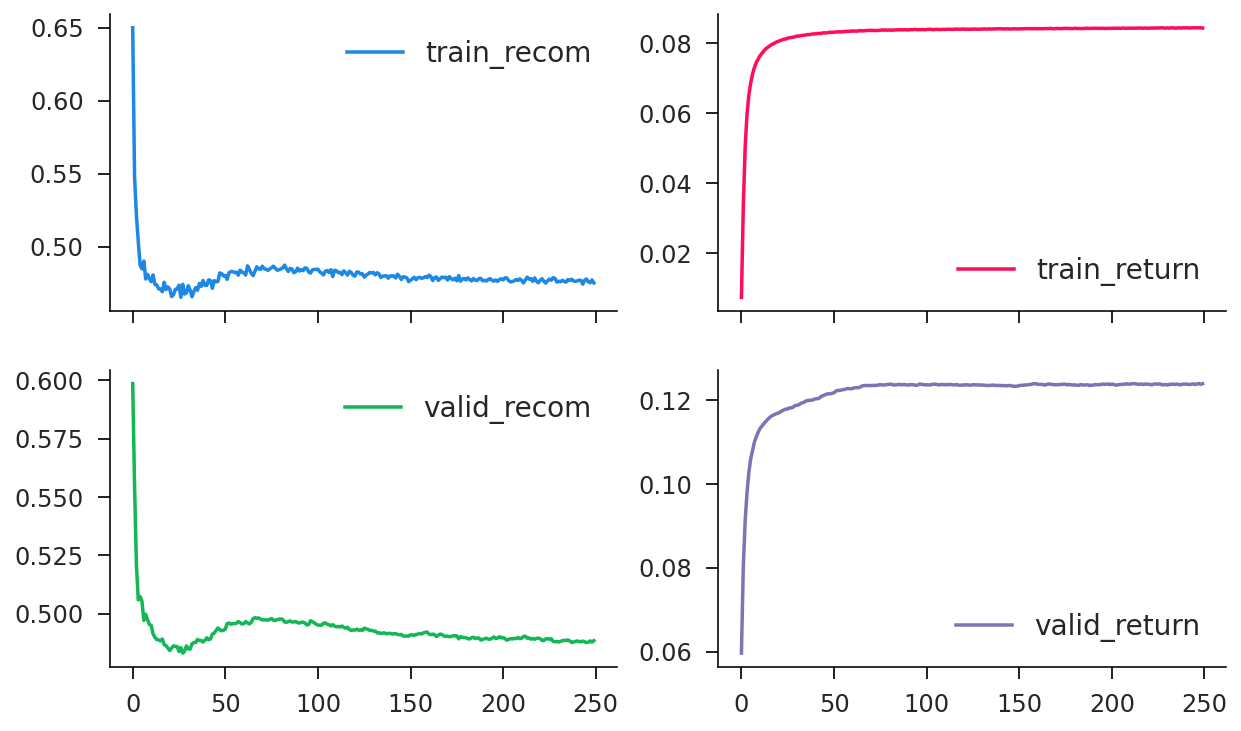

In [23]:
model_moment = NeuralTrader(lag=L, hid=5)
history = neural_trader(model_moment, train_moment_data, valid_moment_data, epochs=250)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

### Dropout

We may be worried about what appears to be overfitting. The algorithm is just fitting noise. One popular approach to this is to use a method called "dropout" in which network connections are randomly severed during training (weights zeroed). This forces the algorithm to "diversify" and ideally reduces overfitting.

In [24]:
# simple neural trader (long only)
class DropoutTrader(nn.Module):
    def __init__(self, lag=4, hid=5, drop=0.5):
        super().__init__()
        self.linear0 = nn.Linear(lag, hid)
        self.linear1 = nn.Linear(hid, 1)
        self.dropout = nn.Dropout(drop)
        self.drop = drop

    def forward(self, x):
        x = self.linear0(x)
        x = torch.sigmoid(x)
        x = self.dropout(x)
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x.squeeze()

100%|█████████████████████████████████████████| 250/250 [00:26<00:00,  9.38it/s]


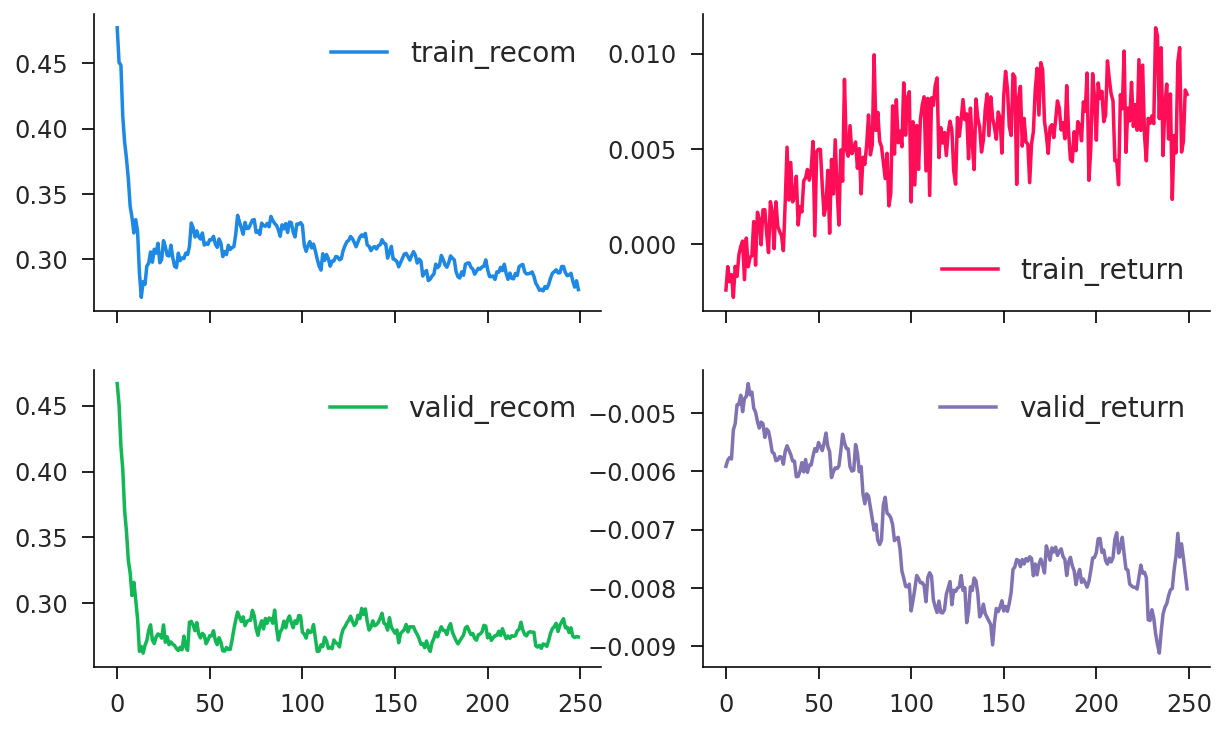

In [25]:
model_random_dropout = DropoutTrader(lag=L, hid=5, drop=0.5)
history = neural_trader(model_random_dropout, train_random_data, valid_random_data, epochs=250)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

100%|█████████████████████████████████████████| 250/250 [00:25<00:00,  9.83it/s]


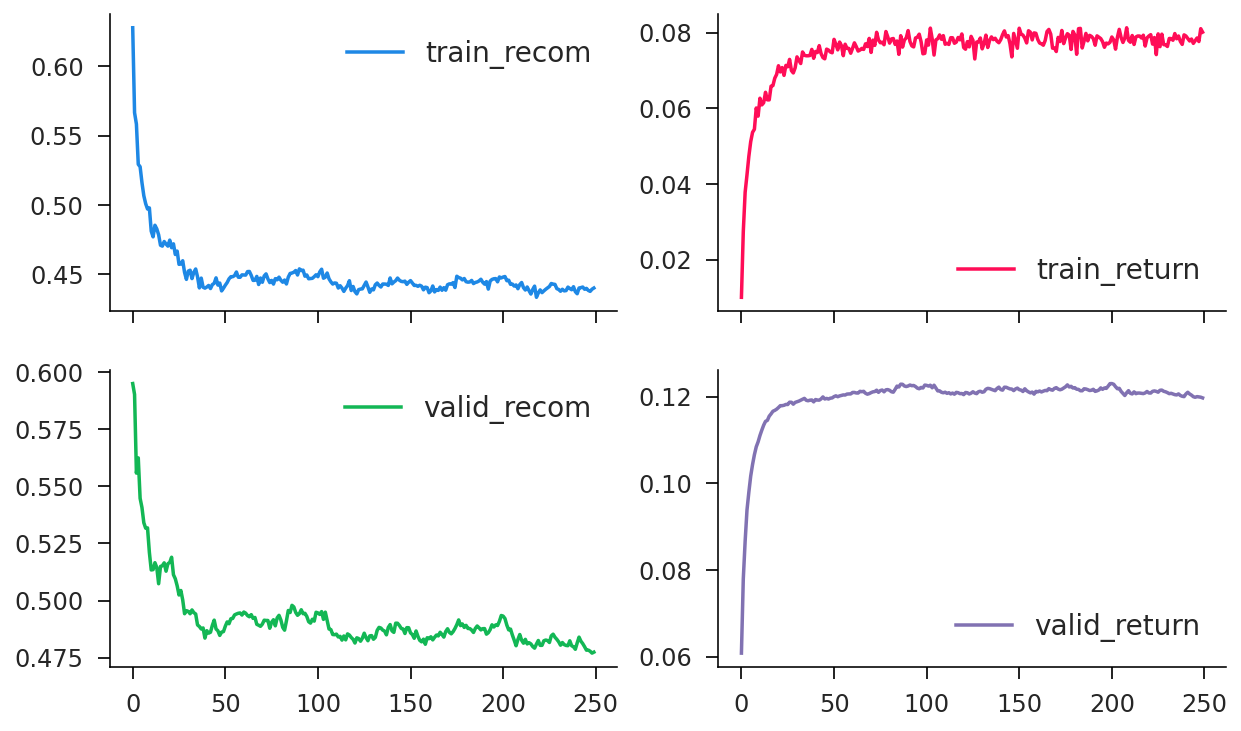

In [26]:
model_moment_dropout = DropoutTrader(lag=L, hid=5, drop=0.5)
history = neural_trader(model_moment_dropout, train_moment_data, valid_moment_data, epochs=250)
history.plot(subplots=True, layout=(2, 2), figsize=(10, 6));

# Data Sources

### Text Vectorization

In [193]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

In [28]:
def process_text(s):
    # merge punctuation
    s = re.sub(r'(;|\-\-)', r',', s)
    s = re.sub(r'([[\-\[\]])', ' ', s)
    s = re.sub(r'([,\.!\?"\(\)])', r' \1 ', s)

    # merge whitespace
    s = re.sub(r'(?<!\n)\n(?!\n)', ' ', s)
    s = re.sub(r'\n{2,}', '\n', s)
    s = re.sub(r' {2,}', ' ', s)

    # strip lines
    s = re.sub(r'(^ +| +$)', r'', s, flags=re.MULTILINE)
    s = re.sub(r'\n', r' \\n ', s)

    return s.lower()

In [29]:
with open('data/moby_dick.txt') as fid:
    moby = fid.read()
print(moby[:432])

[Moby Dick by Herman Melville 1851]


ETYMOLOGY.

(Supplied by a Late Consumptive Usher to a Grammar School)

The pale Usher--threadbare in coat, heart, body, and brain; I see him
now.  He was ever dusting his old lexicons and grammars, with a queer
handkerchief, mockingly embellished with all the gay flags of all the
known nations of the world.  He loved to dust his old grammars; it
somehow mildly reminded him of his mortality.


In [30]:
moby1 = process_text(moby)
print(moby1[:448])

moby dick by herman melville 1851 \n etymology . \n ( supplied by a late consumptive usher to a grammar school ) \n the pale usher , threadbare in coat , heart , body , and brain , i see him now . he was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . he loved to dust his old grammars , it somehow mildly reminded him of his mortality . 


In [227]:
# split moby into chunks
C = 250
words = moby1.split()
Nc = len(words) // C
chunks = [' '.join(words[C*i:C*(i+1)]) for i in range(Nc)]

In [228]:
tfidf = TfidfVectorizer()
vecs = tfidf.fit_transform(chunks)

In [229]:
tsne = TSNE()
embed = tsne.fit_transform(vecs)

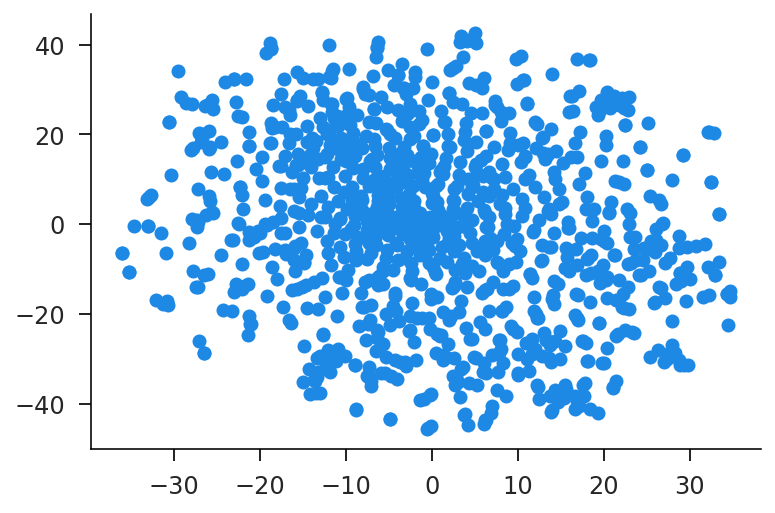

In [230]:
plt.scatter(*embed.T);

In [231]:
print(chunks[np.sum(embed**2, axis=1).argmin()].replace(' \\n ', '\n\n'))

other tribes of his genus .

" there go flukes ! " was now the cry from tashtego , and the whales disappeared .

" quick , steward ! " cried ahab . " time ! time ! "

dough boy hurried below , glanced at the watch , and reported the exact minute to ahab .

the ship was now kept away from the wind , and she went gently rolling before it . tashtego reporting that the whales had gone down heading to leeward , we confidently looked to see them again directly in advance of our bows . for that singular craft at times evinced by the sperm whale when , sounding with his head in one direction , he nevertheless , while concealed beneath the surface , mills round , and swiftly swims off in the opposite quarter , this deceitfulness of his could not now be in action , for there was no reason to suppose that the fish seen by tashtego had been in any way alarmed , or indeed knew at all of our vicinity . one of the men selected for shipkeepers , that is , those not appointed to the boats , by this tim

In [232]:
print(chunks[np.sum(embed**2, axis=1).argmax()].replace(' \\n ', '\n\n'))

that it is all right , that everybody else is one way or other served in much the same way , either in a physical or metaphysical point of view , that is , and so the universal thump is passed round , and all hands should rub each other's shoulder blades , and be content .

again , i always go to sea as a sailor , because they make a point of paying me for my trouble , whereas they never pay passengers a single penny that i ever heard of . on the contrary , passengers themselves must pay . and there is all the difference in the world between paying and being paid . the act of paying is perhaps the most uncomfortable infliction that the two orchard thieves entailed upon us . but being paid , , what will compare with it ? the urbane activity with which a man receives money is really marvellous , considering that we so earnestly believe money to be the root of all earthly ills , and that on no account can a monied man enter heaven . ah ! how cheerfully we consign ourselves to perdition !


### Language Models

In [169]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch.nn.functional as F

In [88]:
tokenizer = get_tokenizer('basic_english')
tokens = tokenizer(moby1)
print(len(tokens))
print(' | '.join(tokens[:91]))

260235
moby | dick | by | herman | melville | 1851 | \n | etymology | . | \n | ( | supplied | by | a | late | consumptive | usher | to | a | grammar | school | ) | \n | the | pale | usher | , | threadbare | in | coat | , | heart | , | body | , | and | brain | , | i | see | him | now | . | he | was | ever | dusting | his | old | lexicons | and | grammars | , | with | a | queer | handkerchief | , | mockingly | embellished | with | all | the | gay | flags | of | all | the | known | nations | of | the | world | . | he | loved | to | dust | his | old | grammars | , | it | somehow | mildly | reminded | him | of | his | mortality | .


In [37]:
vocab = build_vocab_from_iterator([tokens], specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])
indices = vocab(tokens)
print(len(vocab))
print(indices[:91])

17168
[291, 289, 28, 12791, 13800, 5120, 11, 12012, 3, 11, 140, 1813, 28, 6, 720, 11157, 9451, 7, 6, 7860, 2145, 141, 11, 2, 1103, 9451, 1, 16219, 8, 763, 1, 264, 1, 235, 1, 5, 581, 1, 14, 109, 31, 39, 3, 15, 22, 146, 7553, 12, 70, 13526, 5, 7861, 1, 21, 6, 507, 3807, 1, 13901, 5587, 21, 24, 2, 995, 12267, 4, 24, 2, 302, 1767, 4, 2, 165, 3, 15, 5967, 7, 2063, 12, 70, 7861, 1, 13, 508, 2111, 4863, 31, 4, 12, 13949, 3]


In [55]:
class MarkovLanguage(nn.Module):
    def __init__(self, window_len, vocab_size, embed_dim):
        super().__init__()
        self.window_len = window_len
        self.embed_dim = embed_dim
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.flatten = nn.Flatten()
        self.linear0 = nn.Linear(window_len*embed_dim, window_len*embed_dim)
        self.linear1 = nn.Linear(window_len*embed_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear0.weight.data.uniform_(-initrange, initrange)
        self.linear0.bias.data.zero_()
        self.linear1.weight.data.uniform_(-initrange, initrange)
        self.linear1.bias.data.zero_()

    def forward(self, toks):
        x = self.embedding(toks)
        x = x.reshape(-1, self.window_len*self.embed_dim)
        x = F.relu(self.linear0(x))
        x = self.linear1(x)
        return x

In [163]:
def language_model(model, train_data, valid_data, lr=0.01, shuffle=False, epochs=10, batch_size=1000):
    # make data loader
    train_load = torch.utils.data.DataLoader(train_data, shuffle=shuffle, batch_size=batch_size)
    valid_x, valid_y = valid_data.tensors

    # make model and optimizer
    optim = torch.optim.RMSprop(model.parameters(), lr=lr)

    # define loss function
    bce_loss = nn.CrossEntropyLoss()

    # track history
    history = []

    # go for many iterations
    for i in tqdm(range(epochs)):
        n_batch = 0
        train_stats = 0.0
        
        # iterate over batches
        model.train()
        for batch_x, batch_y in train_load:
            # compute loss
            logits = model(batch_x)
            loss = bce_loss(logits, batch_y)

            # update params
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            # training stats
            n_batch += 1
            train_stats += loss.detach().item()

        # average training
        train_stats /= n_batch

        # validation stats
        model.eval()
        valid_logits = model(valid_x)
        valid_loss = bce_loss(valid_logits, valid_y)
        valid_stats = valid_loss.detach().item()

        # make it a mean
        stats = torch.tensor([train_stats, valid_stats])
        history.append(stats)

    # turn history into dataframe
    names = ['train_loss', 'valid_loss']
    return pd.DataFrame(torch.stack(history).numpy(), columns=names)

In [164]:
# make full dataset
M_moby = 1000
seqs, targ = generate_sequences(torch.tensor(indices).reshape(1, -1), W)
moby_data = torch.utils.data.TensorDataset(seqs, targ)
train_split, valid_split = torch.utils.data.random_split(moby_data, [len(moby_data)-M_moby, M_moby])
moby_train = torch.utils.data.TensorDataset(*moby_data[train_split.indices])
moby_valid = torch.utils.data.TensorDataset(*moby_data[valid_split.indices])

In [165]:
# create model (it's a big one)
W, E, V = 10, 20, len(vocab)
lmod = MarkovLanguage(W, V, E)
sum([p.numel() for p in lmod.parameters()])

3834328

In [166]:
hist = language_model(lmod, moby_train, moby_valid)

100%|███████████████████████████████████████████| 10/10 [11:08<00:00, 66.85s/it]


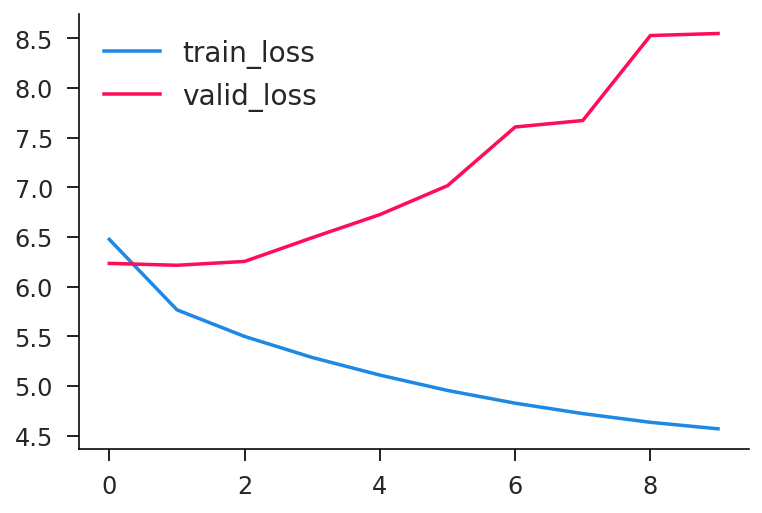

In [167]:
hist.plot();